Sources <br>
https://www.scrapingbee.com/blog/web-scraping-101-with-python/#3-requests--beautifulsoup <br>
https://realpython.com/python-requests/ <br>
Loading the packages

In [25]:
from bs4 import BeautifulSoup # for parsing
import requests # for simplifying web requests
import calendar # for calendar-based scraping
from tqdm import tqdm
import pandas as pd
import nltk
import numpy as np
from tqdm.notebook import tqdm
import simplemma
tqdm.pandas()
nltk.download('punkt')
nltk.download('stopwords')
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import matplotlib.pyplot as plt
import huspacy
import spacy
import pickle
from pathlib import Path
from nltk.stem.snowball import HungarianStemmer

[nltk_data] Downloading package punkt to /Users/sn.lili/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sn.lili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
import huspacy
nlp = huspacy.load()

In [1]:
import hu_core_news_lg
nlp = hu_core_news_lg.load()

# Acquiring the Origo headlines

#### Iterating through the addresses to get all available data 
Used package: calendar

In [3]:
base_url = 'https://www.origo.hu/hir-archivum/'
cal = calendar.Calendar()

In [4]:
datelist = []
for year in range(1998, 2023):
    for month in range(1, 13):
        monthdays = [d for d in cal.itermonthdays(year, month) if d != 0]
        for day in monthdays:
            if month < 10 and day < 10:
                datelist.append(str(year) + '/' + str(year) + '0' + str(month) + '0' + str(day))
            if month >= 10 and day < 10:
                datelist.append(str(year) + '/' + str(year) + str(month) + '0' + str(day))
            if month < 10 and day >= 10:
                datelist.append(str(year) + '/' + str(year) + '0' + str(month) + str(day))
            if month >= 10 and day >= 10:
                datelist.append(str(year) + '/' + str(year) + str(month) + str(day))

 #### Creating a list out of the links where the data will be acquired from

In [77]:
origo_urls = []
for date in l:
    origo_urls.append(base_url + date + '.html')

#### Extracting the headlines using the previously defined list
On the origo archive website the news headlines are defined as h3 type headings, they will be extracted using requests and with beautifulsoup, the text can be obtained omitting the HTML code

In [85]:
headlines = []
for url in tqdm(urls):
    response = requests.get(str(url))
    soup = BeautifulSoup(response.text, 'html.parser')
    news_titles = soup.findAll('h3')
    for title in news_titles:
        headlines.append(title.text)

100%|████████████████████████████████████████████████████████| 9131/9131 [22:08<00:00,  6.87it/s]


In [358]:
len(headlines)

755517

In total, I found 755 517 headlines
#### Conversion into dataframe and exporting the result as a csv file
using pandas 

In [230]:
headline_df = pd.DataFrame(headlines, columns = ['headline'])
headline_df.to_csv('headlines.csv', encoding = 'utf-8')

Loading the csv as a pandas data frame

In [5]:
headline_df = pd.read_csv('headlines.csv')
del headline_df['Unnamed: 0']

### Processing the text

In [6]:
headline_df

,headline
0,Történelmi siker kézilabdában
1,Bajnokok Ligája-eredmények
2,Az évszázad botránya közelít a spanyol futball...
3,Orbán: Ez Európa lerombolása
4,Optimista terv volt teherautóval átkelni a hídon
...,...
755512,Varga Mihály: Magyarország sikeresen bocsátott...
755513,Egy országban különleges adót vetnének ki a sz...
755514,A világűrben koncertezne Kanye West
755515,Kína bemutatta a világ első önvezető drónhordo...


#### NLTK

In [50]:
# add tokenized titles to new column
headline_df['tokenized_headlines'] = headline_df.progress_apply(lambda row: nltk.word_tokenize(row['headline']), axis=1)

  0%|          | 0/755517 [00:00<?, ?it/s]

In [51]:
# Stopwords
from nltk.corpus import stopwords
swords = stopwords.words("hungarian")
headline_df['tokenized_headlines'] = headline_df['tokenized_headlines'].progress_apply(lambda x: [item for item in x if item not in swords])

  0%|          | 0/755517 [00:00<?, ?it/s]

In [52]:
# Lemmatization - load package (contains information on Hungarian words)
langdata = simplemma.load_data('hu')

In [53]:
headline_df['lemmatized_headlines'] = headline_df['tokenized_headlines'].progress_apply(lambda x: [simplemma.lemmatize(item, langdata) for item in x])

  0%|          | 0/755517 [00:00<?, ?it/s]

The lemmatization with the nltk package does not work so well, so I will add a column using stemming

### Gathering words attributable to women and men
- Hungarian first names
- English first names
- feminine/masculine family or profession-related expressions

Sources: <br>
http://benoke98.f.fazekas.hu/alapadatok/ <br>
https://github.com/organisciak/names/raw/master/data/us-living-estimate-names-by-sex-state-year.csv

In [13]:
hunames = pd.read_csv('anyakonyvezheto_utonevek_2019_08.csv', delimiter=';')
male_words = hunames[hunames.nem == 1].nev.tolist()
female_words = hunames[hunames.nem == 2].nev.tolist()

In [14]:
ennames = pd.read_csv('us-living-estimate-names-by-sex-state-year.csv')
ennames = ennames[ennames.year == 2013]
male_en = ennames[ennames.sex == 'M'].name.tolist()
for name in male_en:
    male_words.append(name)

In [15]:
female_en = ennames[ennames.sex == 'F'].name.tolist()
for name in female_en:
    female_words.append(name)

Removing confusing names and duplicates

In [16]:
female_words = list(set(female_words))

In [17]:
removelist_f = ['London', 'Európa' 'Berlin', 'Paris', 'Színes', 'Mercedes', 'Remény', 'Áfonya', 'Ajándék', 'Ember', 'Csillag', 'Fortuna', 'India']
female_words = [word for word in female_words if word not in removelist_f]

#### Extending the list by some additional words

In [18]:
female_words.extend(['barátnő', 'nő', 'ápolónő', 'feleség', 'húg', 'nővér', 'lány', 'anya', 'bombázó', 'szépség',
                    'színésznő', 'csaj', 'nővér', 'anya', 'kislány', 'hercegné', 'hercegnő', 'királynő', 'turistalány',
                    'védőnő', 'tanárnő'])

male_words.extend(['fiú', 'férfi', 'férj', 'báty', 'öcs', 'apa', 'kisfiú', 'újságíró', 'király', 'herceg'])

Lemmatized headlines - women

In [466]:
female_headlines_lem = []
headline_df['lemmatized_headlines'].progress_apply(lambda headline: [female_headlines_lem.append(headline) for lemma in headline if lemma in female_words])

  0%|          | 0/755517 [00:00<?, ?it/s]

0             []
1             []
2             []
3         [None]
4             []
           ...  
755512        []
755513        []
755514        []
755515        []
755516        []
Name: lemmatized_headlines, Length: 755517, dtype: object

In [54]:
male_headlines_lem = []
headline_df['lemmatized_headlines'].progress_apply(lambda headline: [male_headlines_lem.append(headline) for lemma in headline if lemma in male_words])

  0%|          | 0/755517 [00:00<?, ?it/s]

0             []
1             []
2             []
3         [None]
4             []
           ...  
755512    [None]
755513        []
755514    [None]
755515        []
755516        []
Name: lemmatized_headlines, Length: 755517, dtype: object

In [34]:
female_lem_context = []
for headline in tqdm(female_headlines_lem):
    for word in headline:
        if word not in (female_words):
            female_lem_context.append(word)

  0%|          | 0/52373 [00:00<?, ?it/s]

In [55]:
male_lem_context = []
for headline in tqdm(male_headlines_lem):
    for word in headline:
        if word not in (male_words):
            male_lem_context.append(word)

  0%|          | 0/109574 [00:00<?, ?it/s]

In [47]:
female_lem_context_1 = []
swords_addition = [',', '?', '.', ':', '(', ')', '!', '-', 'is', 'ha']
[swords.append(symbol) for symbol in swords_addition]
for word in tqdm(female_lem_context):
    if word not in swords:
        female_lem_context_1.append(word)

  0%|          | 0/279256 [00:00<?, ?it/s]

In [58]:
male_lem_context_1 = []
swords_addition = [',', '?', '.', ':', '(', ')', '!', '-', 'is', 'ha', 'akár']
[swords.append(symbol) for symbol in swords_addition]
for word in tqdm(male_lem_context):
    if word not in swords:
        male_lem_context_1.append(word)

  0%|          | 0/590955 [00:00<?, ?it/s]

(-0.5, 1999.5, 999.5, -0.5)

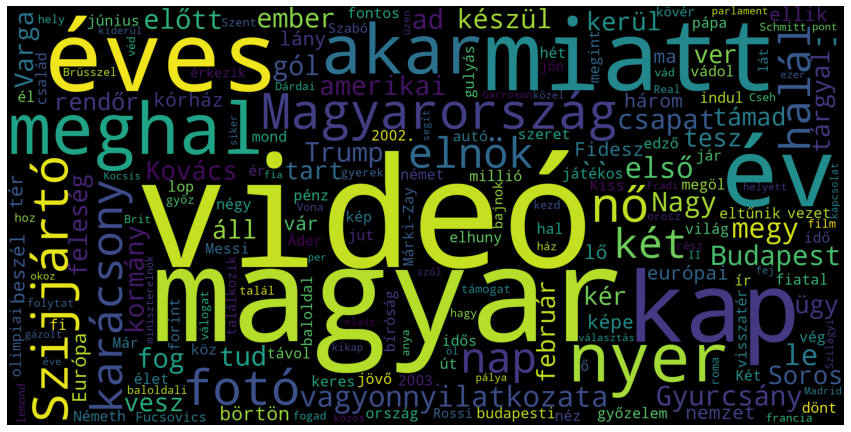

In [59]:
word_cloud_dict=Counter(male_lem_context_1)
wordcloud=WordCloud(width = 2000, height = 1000).generate_from_frequencies(word_cloud_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
nlp.max_length = 2641387
doc_fem = nlp(str(female_lem_context_1))

In [ ]:
doc_male = nlp(str(male_lem_context_1))